In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
 
from os.path import join as pjoin
import numpy as np
from numpy import hstack as stack
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.stattools import acf

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


#### Trend extraction for non-seasonal time series of the crude oil price

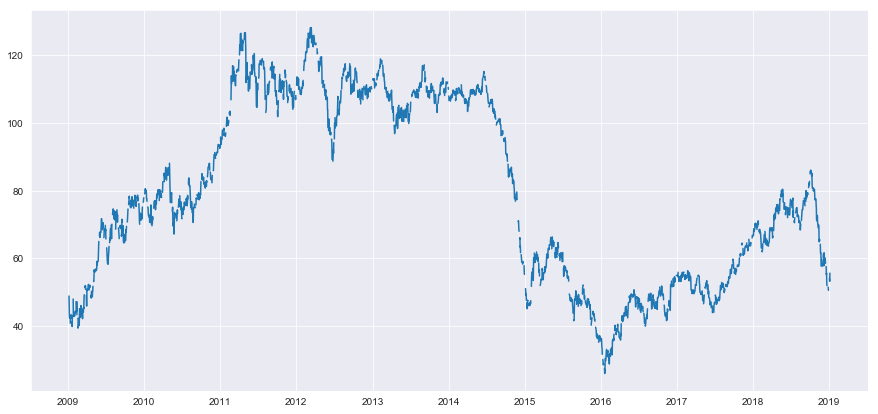

In [7]:
mpl.rcParams['figure.figsize'] = (15,7)

CrudeOil = pd.read_csv('data/CrudeOil.csv', header=0, index_col=0,
                       squeeze=True)
N = len(CrudeOil)
dateIndex = pd.DatetimeIndex(start=CrudeOil.index[0], end=CrudeOil.index[-1],
                             freq='D')
train = pd.Series(data=[np.nan]*len(dateIndex), index=dateIndex)
train.loc[CrudeOil.index.astype('datetime64[ns]')] = CrudeOil.values
plt.plot(train)
plt.show()

> Before extracting the trend of this TS first we need to deal with missing values. Suggestion: interpolation with splines.

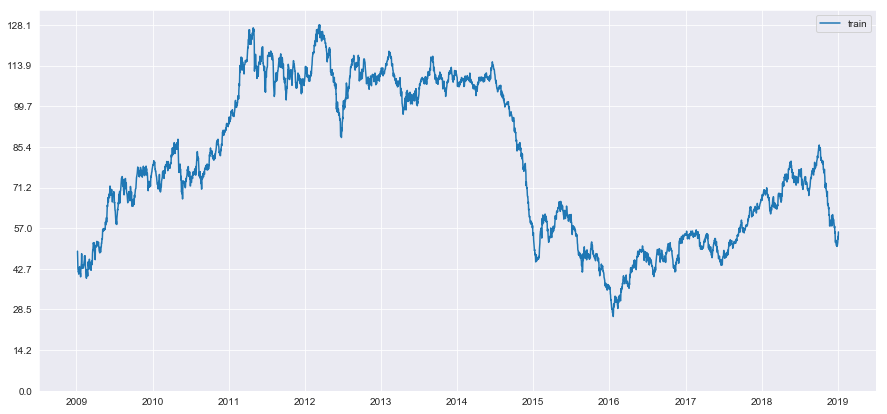

Closer look:


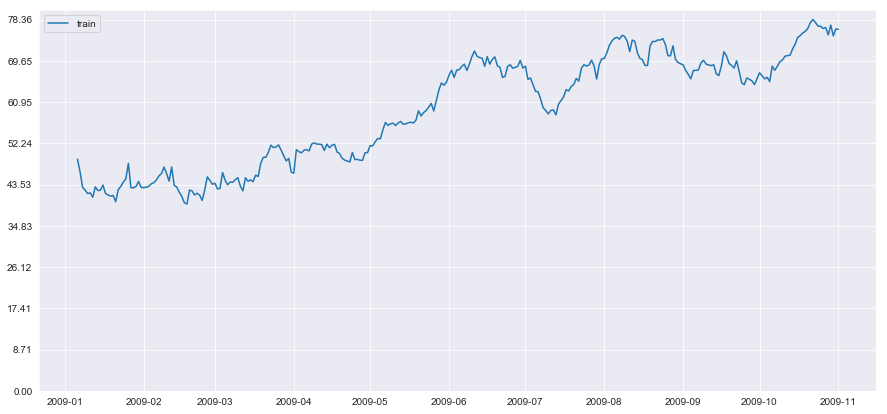

In [13]:
train = train.interpolate(method='spline', order=3)

mpl.rcParams['figure.figsize'] = (15,7)
show_series(train, x_freq=400)
plt.show()
print('Closer look:')
show_series(train[:300], x_freq=100)
plt.show()

##### (a) Try several moving average techniques to extract the trend (ma in R). Which orders/form of moving averages do provide the best results? Use just ﬁgures of the trend and the diﬀerence $Y_t − T_t$.

In [14]:
trends = {'simple': {}, 'centered': {}, 'double': {}}
for i, p in enumerate([31,91,183,365]):
    trends['simple'][p] = trend_MA(train, p, 'simple')

for i, p in enumerate([30,92,182,366]):
    trends['centered'][p] = trend_MA(train, p, 'centered')
    
for i, p in enumerate([31,91,183,365]):
    trends['double'][p] = trend_MA(train, p, 'double')

Simple Moving Average


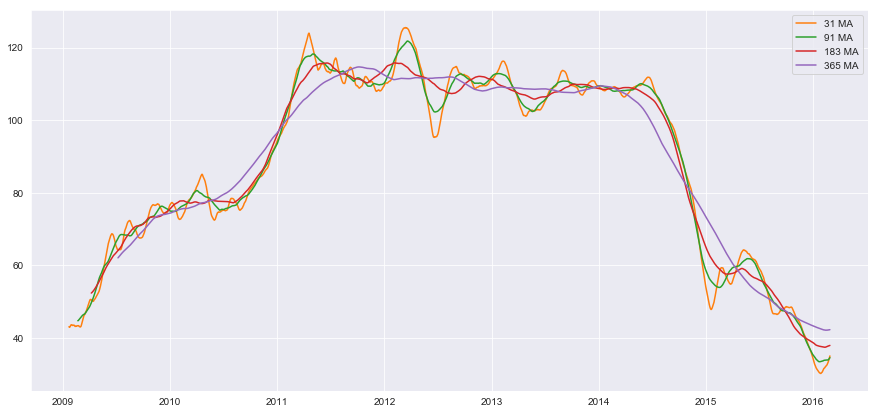

Closer:


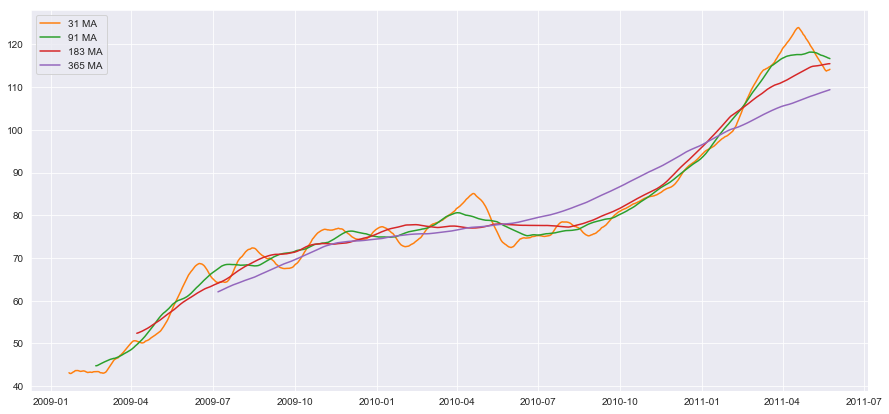

Differences:


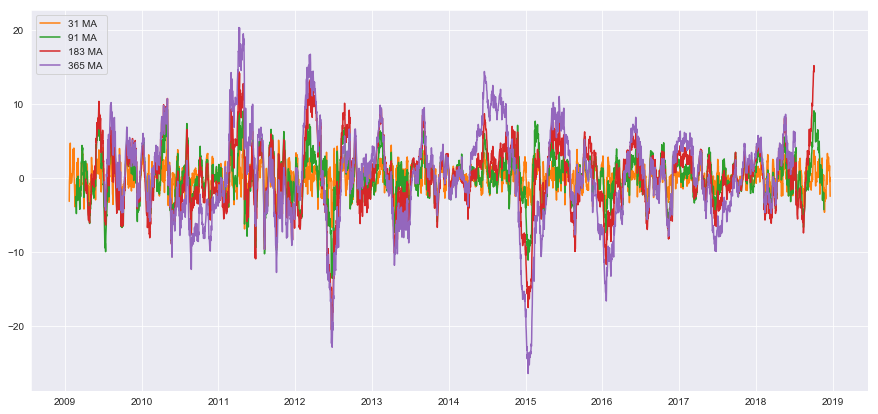

In [15]:
mpl.rcParams['figure.figsize'] = (15,7)
print('Simple Moving Average')
for k in [N, N//3]:
    if k != N:
        print('Closer:')
#     show_series(train[:k], x_freq=400)
    for i, p in enumerate(trends['simple'].keys()):
        trend = trends['simple'][p]
        plt.plot(trend[(p - 1)// 2:k], color='C{}'.format((i+1)%10),
                 label='{} MA'.format(p))
    plt.legend()
    plt.show()
    
print('Differences:')
for i, p in enumerate(trends['simple'].keys()):
    trend = trends['simple'][p]
    plt.plot(train - trend[(p - 1)// 2:], color='C{}'.format((i+1)%10),
             label='{} MA'.format(p))
plt.legend()
plt.show()

Centered Moving Average


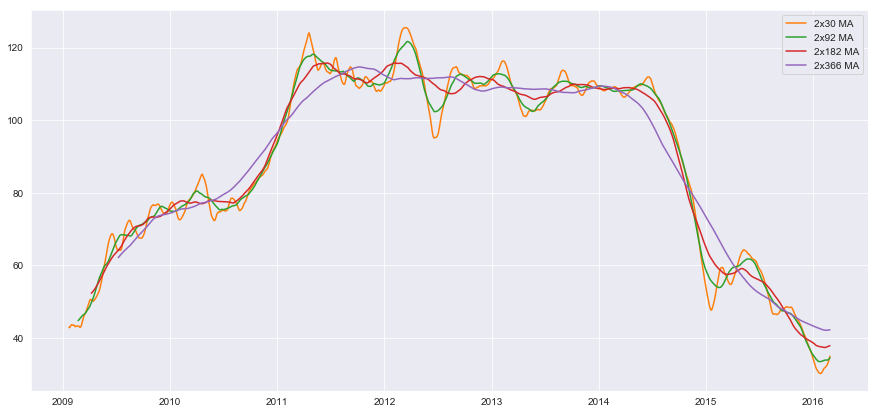

Closer:


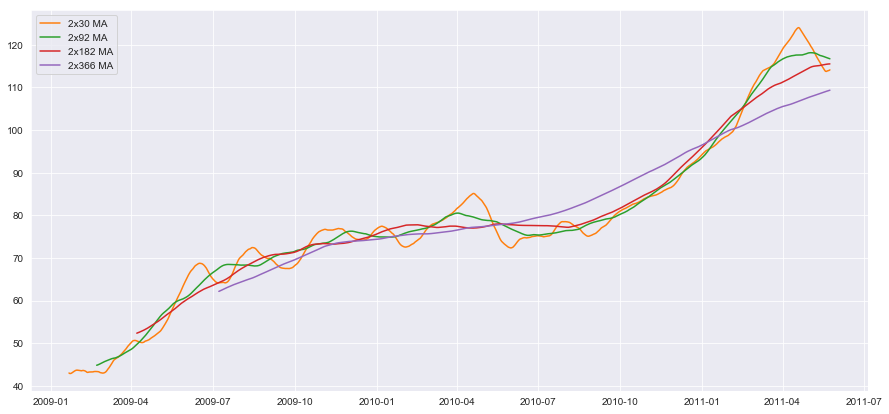

Differences:


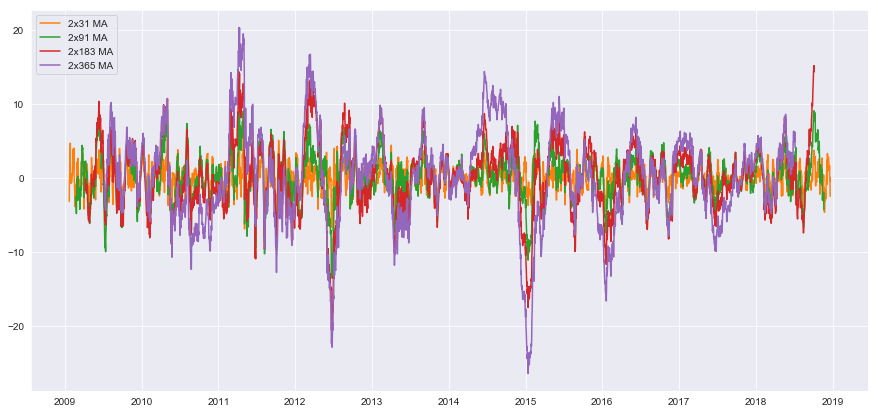

In [16]:
print('Centered Moving Average')
for k in [N, N//3]:
    if k != N:
        print('Closer:')
#     show_series(train[:k], x_freq=400)
    for i, p in enumerate(trends['centered'].keys()):
        trend = trends['centered'][p]
        plt.plot(trend[p//2:k], color='C{}'.format((i+1)%10),
                 label='2x{} MA'.format(p))
    plt.legend()
    plt.show()
    
print('Differences:')
for i, p in enumerate(trends['simple'].keys()):
    trend = trends['simple'][p]
    plt.plot(train - trend[p// 2:], color='C{}'.format((i+1)%10),
             label='2x{} MA'.format(p))
plt.legend()
plt.show()

Double Moving Average


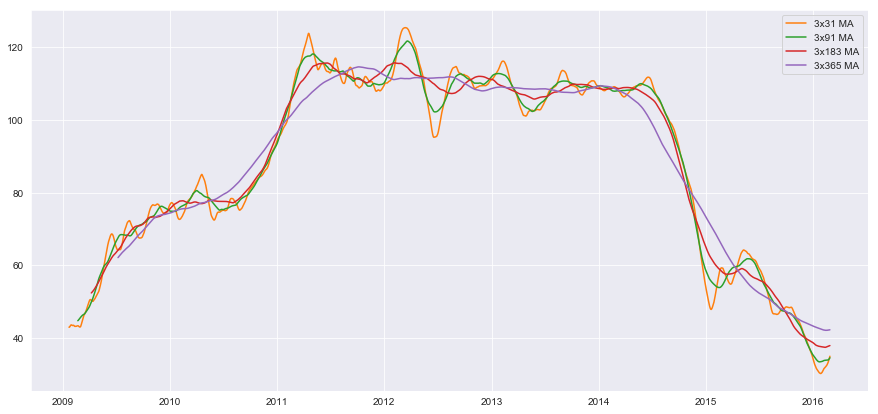

Closer:


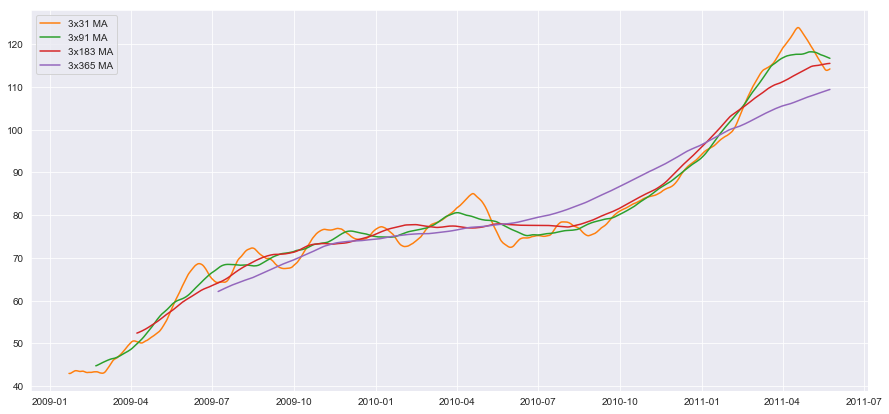

Differences:


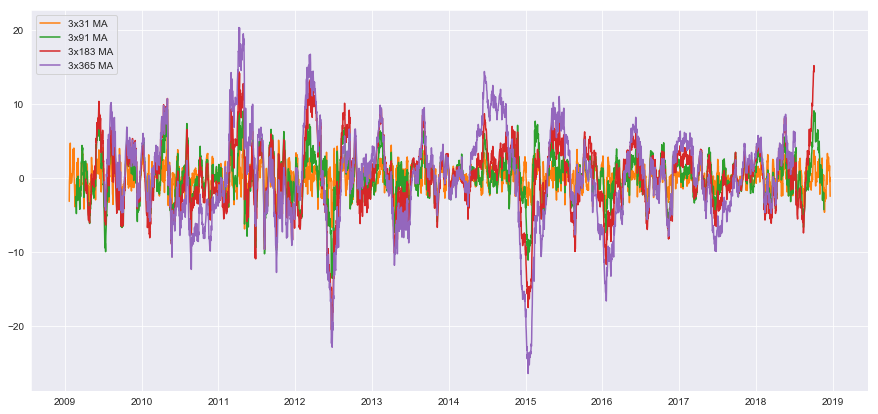

In [17]:
print('Double Moving Average')
for k in [N, N//3]:
    if k != N:
        print('Closer:')
#     show_series(train[:k], x_freq=400)
    for i, p in enumerate(trends['double'].keys()):
        trend = trends['double'][p]
        plt.plot(trend[(p - 1)// 2:k], color='C{}'.format((i+1)%10),
                 label='3x{} MA'.format(p))
    plt.legend()
    plt.show()
    
print('Differences:')
for i, p in enumerate(trends['simple'].keys()):
    trend = trends['simple'][p]
    plt.plot(train - trend[(p - 1)// 2:], color='C{}'.format((i+1)%10),
             label='3x{} MA'.format(p))
plt.legend()
plt.show()

> All the residuals look like having no trend. The bigger is order of moving average, the higher is residual variability, but the smoother is the trend model. However we may be interested in different periods changes. I would say, two models look the best: 3-month moving average removes the irregular component and preserves the tendency over quarters, and 1-year moving average eliminates a most of fluctuations and explains changes over years.

##### (b) Does it make sense to apply centered moving average (2 × k MA) smoothing? Explain and motivate your answer.

> We have daily observations, therefore we may apply moving average for e.g. 2 weeks (14 days), month (30 days), 3 months (92 days), half-year (182 days) etc. So it makes sense to apply centered moving average. And simple / double as well (for 31, 91, 183, 365 days corresponding to a month, quater, half-year and year).

##### (c) Since the time series exhibits a very irregular trend apply and visualize the local polynomial regression. In your particular implementation verify the functional form of the weights used for trend extraction.

In [18]:
train_ = train.copy()
train_.index = np.arange(len(train))

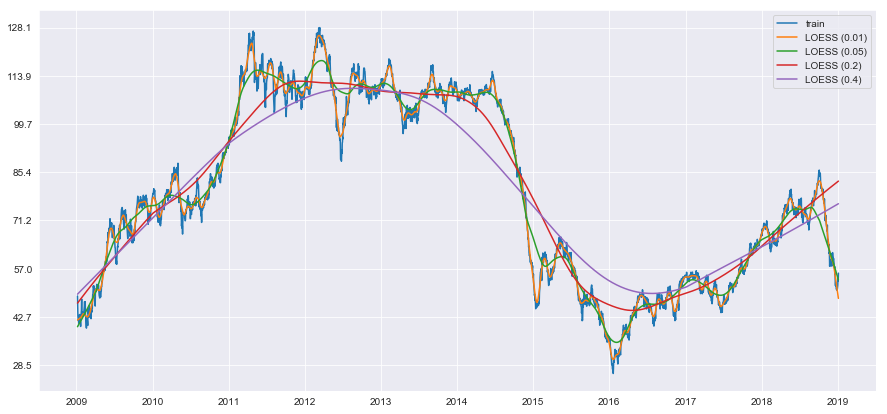

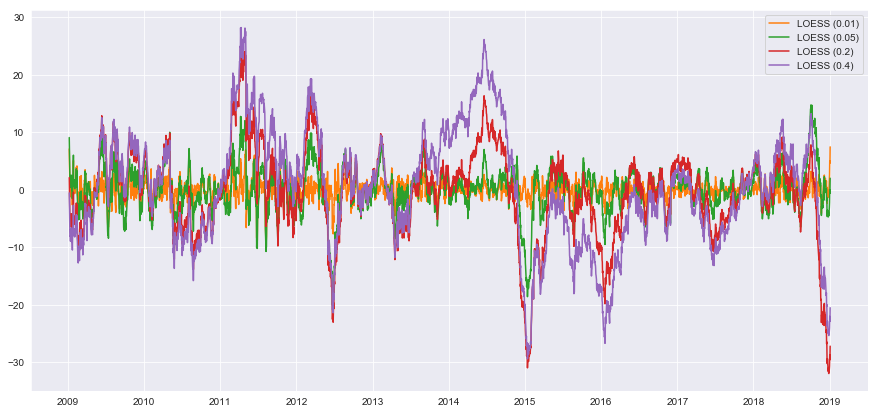

In [79]:
mpl.rcParams['figure.figsize'] = (15,7)
from statsmodels.nonparametric.smoothers_lowess import lowess

show_series(train, x_freq=400)
trends['LOESS'] = {}
fracs = [0.01, 0.05, 0.2, 0.4]
for i, frac in enumerate(fracs):
    trend = lowess(train_.values, train_.index, frac=frac,
                   missing='drop', return_sorted=False)
    trend = pd.Series(trend, index=train.index)
    trends['LOESS'][frac] = trend
    plt.plot(trend, color='C{}'.format(i+1), label='LOESS ({})'.format(frac))
plt.legend()
plt.show()

for i, frac in enumerate(fracs):
    trend = trends['LOESS'][frac]
    plt.plot(train - trend, color='C{}'.format((i+1)%10),
             label='LOESS ({})'.format(frac))
plt.legend()
plt.show()

> In this implementation the weight function is a tricube function: $w(u) = (1 - |u|^3) ^3$ if $|u| \leq 1$ otherwise $0$.

> The fraction used for local estimate is chosen to be 5%, 20%, 40% (corresponding to different the bandwidth parameter values). The model with fraction 20% looks like the best for trend extracting.

##### (d) Apply the B-spline approach to extract the trend. Explain precisely how many splines you use, the underlying time grid and the order of polynomials.

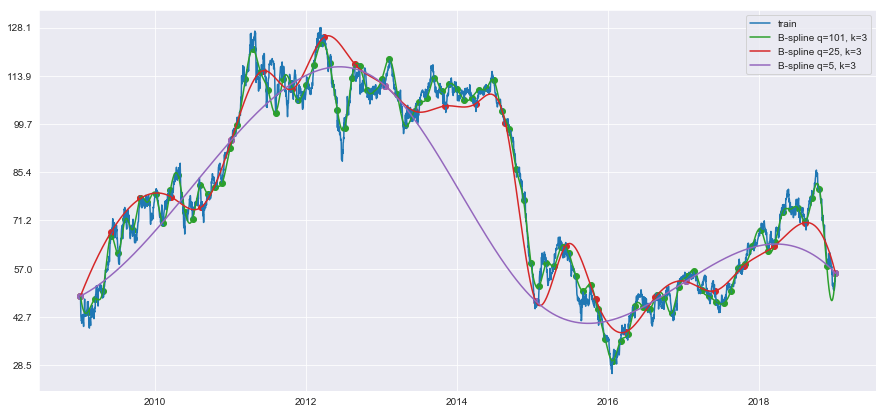

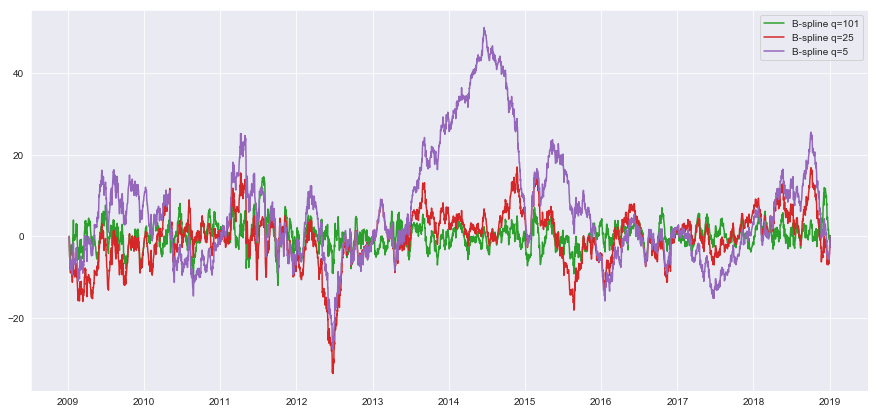

In [92]:
mpl.rcParams['figure.figsize'] = (15,7)
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

X = []
for date in CrudeOil.dropna().index.astype('datetime64[ns]').date:
    X.append(train.index.get_loc(date))
X = np.array(X)
Y = CrudeOil.dropna().values
full_N = len(X)

show_series(train)
# for i, freq in enumerate([50,100,200,500]):
trends['spline'] = {}
for i, freq in enumerate(divisors(full_N-1)[1:]):
    q = (full_N-1) // freq
    x = X[:(full_N-1)+freq:freq]
    y = Y[:(full_N-1)+freq:freq]

    t, c, k = interpolate.splrep(x, y, k=3)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    spline_model = pd.Series(spline(train_.index), index=train.index)
    trends['spline'][q] = spline_model
    if q != 505:
        plt.scatter(train.index[x], y, color='C{}'.format(i+1))
        plt.plot(spline_model, color='C{}'.format(i+1),
                 label='B-spline q={}, k={}'.format(q, k))
        plt.legend()
plt.show()

for i, q in enumerate(trends['spline'].keys()):
    if q != 505:
        trend = trends['spline'][q]
        plt.plot(train - trend, color='C{}'.format((i+1)%10),
                 label='B-spline q={}'.format(q))
plt.legend()
plt.show()

> The `q` parameter was chosen with respect to the length of TS s.t. to get equally spaced time grid, and more specifically: $q_1=101$ (time grid width is 25), $q_2=25$ (time grid width is 101), $q_3=5$ (time grid width is 505). The lower values were not considered due to inadequate results. The same reason is for values of $q > 101$ $-$ such interpolations keep the irregular components/seasonalities. The degree (order) of polynomials for all the three cases is chosen to be $k=3$ since it is recommended to use it, and other degree values give much worse results.

##### (e) For every of the above approaches extract the irregular component (there is no seasonal component) and plot its autocorrelation.

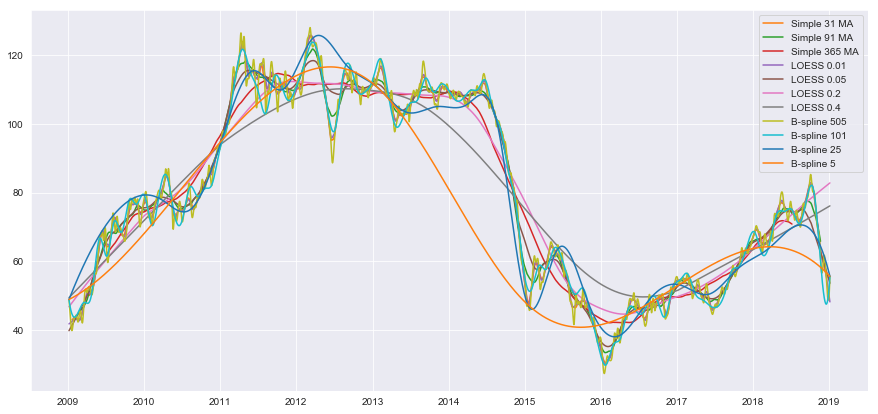

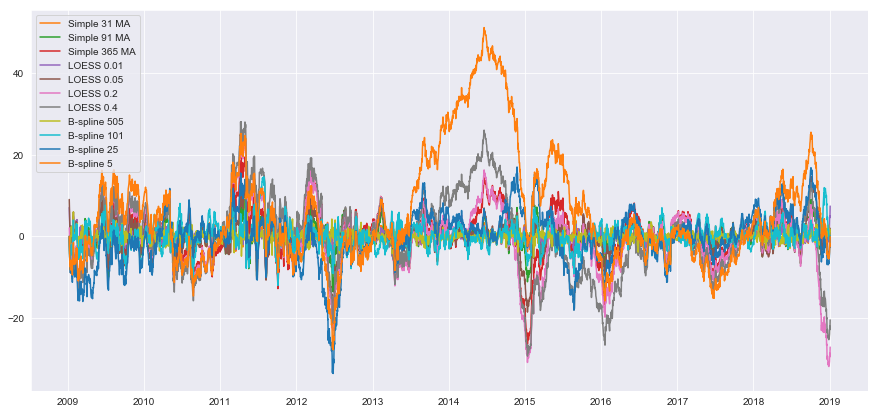

In [83]:
T = {}
T['Simple 31 MA'] = trends['simple'][31]
T['Simple 91 MA'] = trends['simple'][91]
T['Simple 365 MA'] = trends['simple'][365]
T['LOESS 0.01'] = trends['LOESS'][0.01]
T['LOESS 0.05'] = trends['LOESS'][0.05]
T['LOESS 0.2'] = trends['LOESS'][0.2]
T['LOESS 0.4'] = trends['LOESS'][0.4]
T['B-spline 505'] = trends['spline'][505]
T['B-spline 101'] = trends['spline'][101]
T['B-spline 25'] = trends['spline'][25]
T['B-spline 5'] = trends['spline'][5]


mpl.rcParams['figure.figsize'] = (15,7)
for i, p in enumerate(T.keys()):
    plt.plot(T[p], color='C{}'.format((i+1)%10), label='{}'.format(p))
plt.legend()
plt.show()

for i, p in enumerate(T.keys()):
    plt.plot(train-T[p], color='C{}'.format((i+1)%10), label='{}'.format(p))
plt.legend()
plt.show()

In [84]:
Model, Res = [], []
for p in T.keys():
    Model.append(p)
    Res.append(list((T[p] - train).dropna()))
Res = np.array(Res)

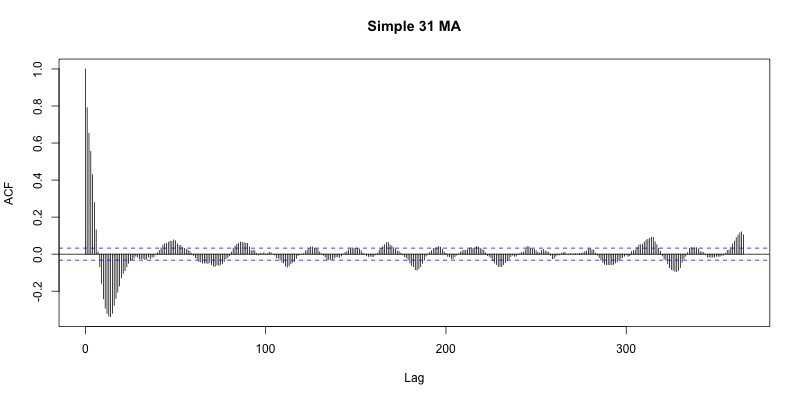

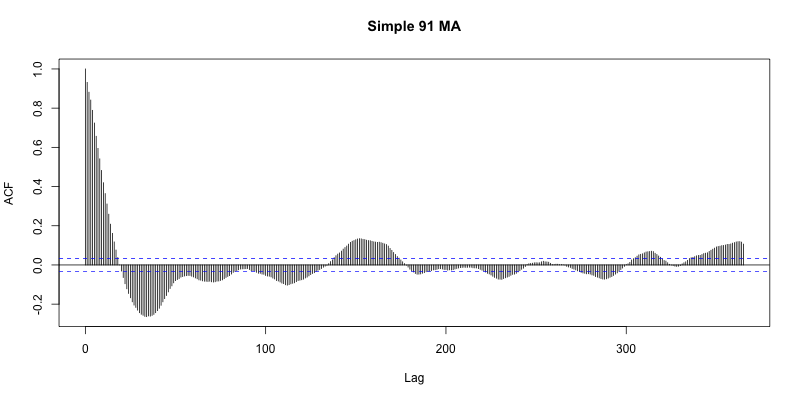

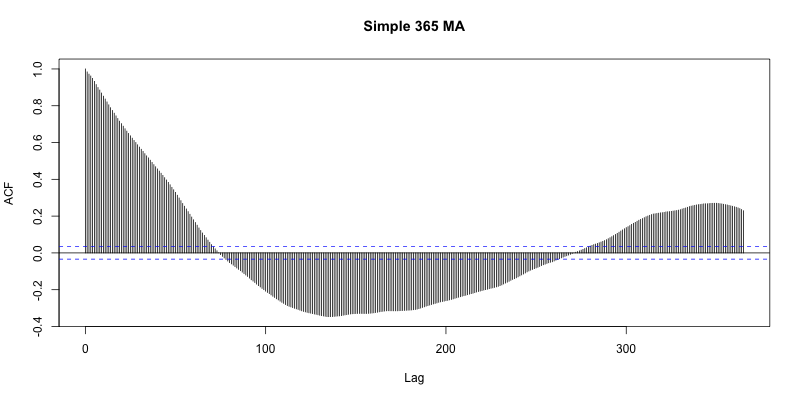

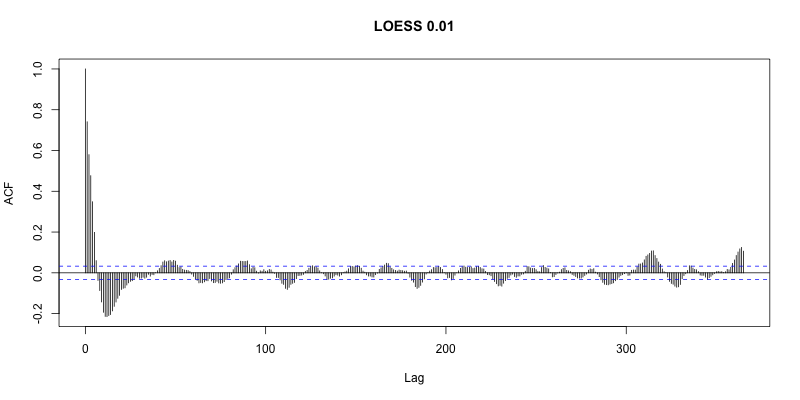

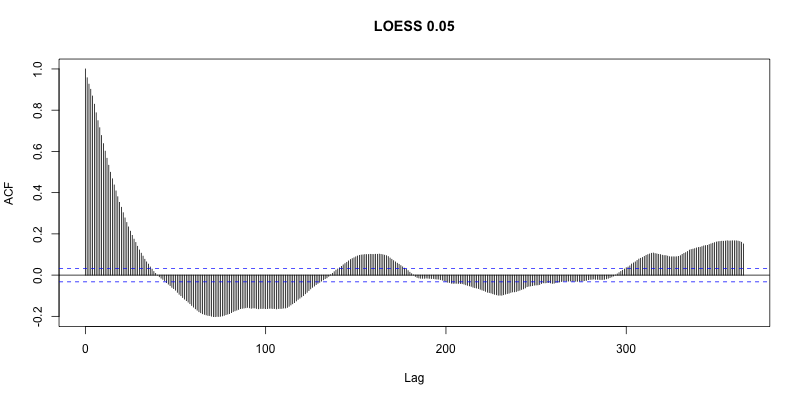

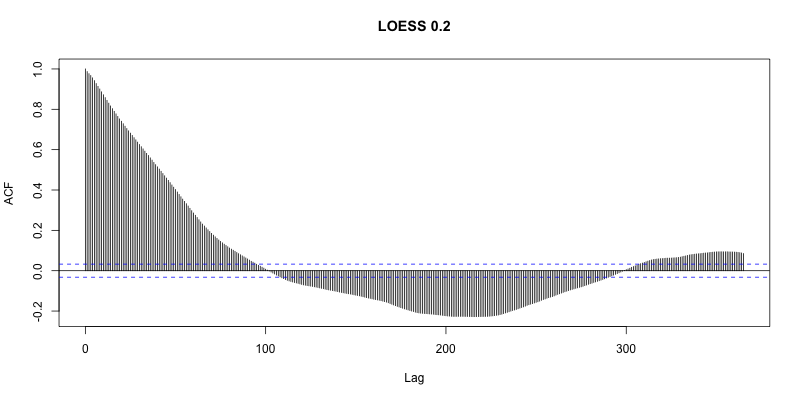

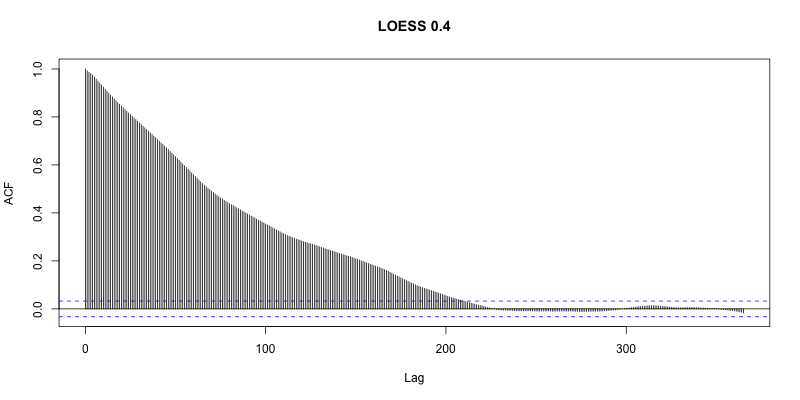

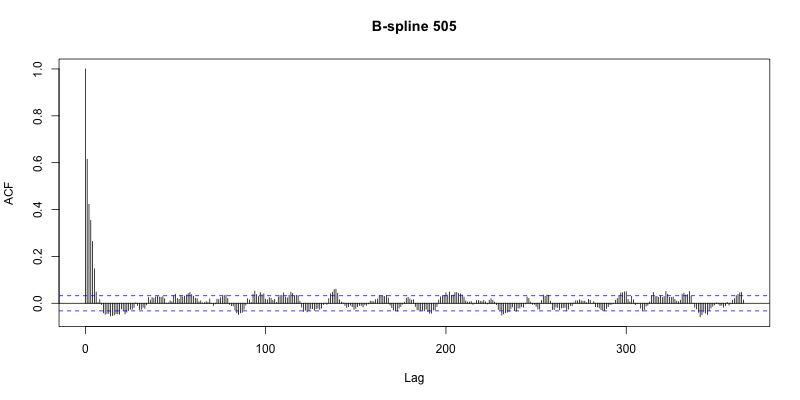

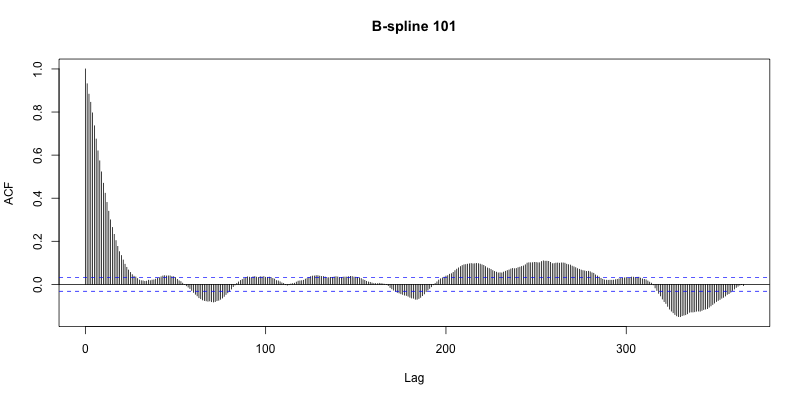

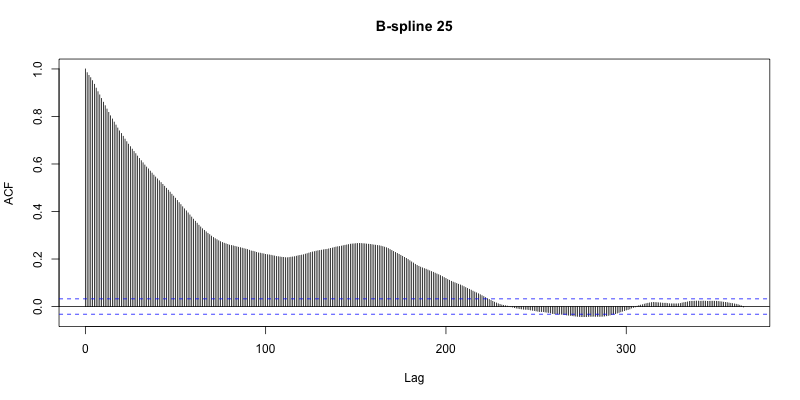

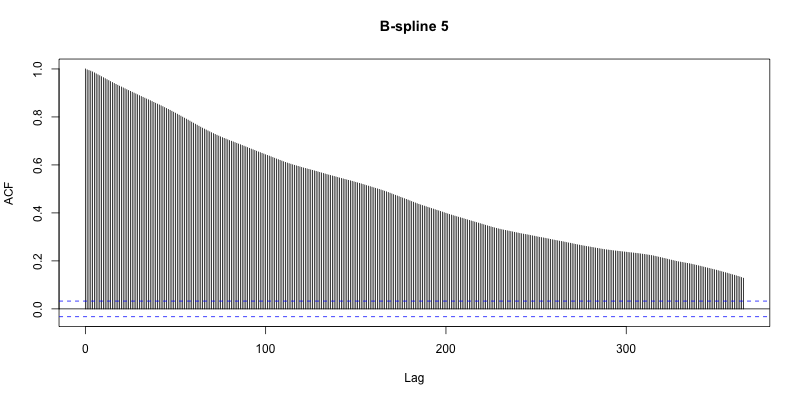

In [85]:
%%R -i Res -i Model -w 800 -h 400 -u px
library('forecast')
library('tseries')

names(Res) <- Model
for (name in names(Res))
{
AutoCorrelation <- acf(as.numeric(Res[[name]]), lag.max=365, plot = FALSE)
plot(AutoCorrelation, main = name)
}

> One can notice that for the models extracting trend very locally the ACF of residual component quickly falls and has merely no significant lags. The more global model is, the more slowly falls the ACF, which is logical since such trends smooth the TS very much and leave a lot of information in the residuals.

##### If there are signiﬁcant lags, is this good or bad for further analysis?

> In case of existing significant lags the residual component should have some pattern / indicate having some memory, and, in fact, is not an irregular component. It may also be decomposed (depending on the ACF looking; if it is slowly falling down, we can extract the trend once again), or may be modeled somehow further. So I would say, this is neither good nor bad, it just tells that further steps have to be taken to extract useful information from the residuals.